## Configure Jupyter notebook

In [2]:
### JUPYTER NOTEBOOK CONFIG
%load_ext autoreload
%autoreload 2

working_dir = '/Users/hintont/Dev/Ridgecrest'

## Helper functions

In [3]:
import xarray as xr
def get_perpendicular_profile(segment_xs, segment_ys, grid, max_length=5000):
    """
    Draw a perpendicular profile through a segment midpoint until it hits NaN values.
    
    Parameters:
    - segment_xs, segment_ys: start and end coordinates of the segment
    - grid: xarray.DataArray with x, y coordinates and data with potential NaN values
    - max_length: maximum length to extend in each direction (as safety limit)
    
    Returns:
    - profile_xs, profile_ys: coordinates of the perpendicular profile line
    """
    # Calculate midpoint
    mid_x = (segment_xs[0] + segment_xs[1]) / 2
    mid_y = (segment_ys[0] + segment_ys[1]) / 2
    
    # Calculate segment direction vector
    seg_dx = segment_xs[1] - segment_xs[0]
    seg_dy = segment_ys[1] - segment_ys[0]
    seg_length = np.sqrt(seg_dx**2 + seg_dy**2)
    
    # Normalize segment direction
    seg_dx_norm = seg_dx / seg_length
    seg_dy_norm = seg_dy / seg_length
    
    # Perpendicular direction (rotate 90 degrees)
    perp_dx = -seg_dy_norm
    perp_dy = seg_dx_norm
    
    # Extend profile in both directions until hitting NaN
    profile_xs = [mid_x]
    profile_ys = [mid_y]
    
    # Extend in positive direction
    step_size = 10  # meters per step
    for direction in [-1, 1]:  # -1 for negative direction, 1 for positive
        x, y = mid_x, mid_y
        for step in range(int(max_length / step_size)):
            x += direction * perp_dx * step_size
            y += direction * perp_dy * step_size
            
            # Check if point is within grid bounds
            if x < float(grid.x.min()) or x > float(grid.x.max()) or \
               y < float(grid.y.min()) or y > float(grid.y.max()):
                break
            
            # Interpolate grid value at this point
            try:
                val = float(grid.interp(x=x, y=y, method='nearest'))
                if np.isnan(val):
                    break
            except:
                break
            
            if direction == -1:
                profile_xs.insert(0, x)
                profile_ys.insert(0, y)
            else:
                profile_xs.append(x)
                profile_ys.append(y)
    
    return profile_xs, profile_ys

def sample_profile_values(grid, xs, ys, method='linear'):
    """
    Sample values from an xarray.DataArray `grid` at the pairwise points (xs[i], ys[i]).
    Returns a 1D numpy array of sampled values (NaN preserved).
    """
    # create 1D DataArrays with a single dim 'points' so interp returns matching 1D array
    pts_x = xr.DataArray(xs, dims="points")
    pts_y = xr.DataArray(ys, dims="points")
    sampled = grid.interp(x=pts_x, y=pts_y, method=method)
    return sampled.values

import numpy as np
import pymc as pm
import arviz as az

def solve_homogeneous(xs, s, d):
    sol = (s / np.pi) * np.arctan(d / xs)
    return sol
def solve_segmented(xs, segments):
    sol = np.zeros(len(xs))
    for seg in segments:
        sol += solve_homogeneous(xs, seg['slip'], seg['bottom']) - solve_homogeneous(xs, seg['slip'], seg['top'])
    return sol
def pred_func_segmented_generator(xs, segments):
    def pred_func(slip_arr):
        segments_filled_in = segments.copy()
        for i, slip in enumerate(slip_arr):
            segments_filled_in[i]['slip'] = slip
        preds = solve_segmented(xs, segments_filled_in)
        return preds
    return pred_func
def run_bayesian_inversion_segmented(xs, obs, segments, lin_center, C):

    # Linearization center and forward operator (kept as plain numpy arrays)
    pred_func = pred_func_segmented_generator(xs, segments)
    p0 = np.array(lin_center, dtype=float)
    preds0 = pred_func(p0)                              # (n_obs,)
    # Jacobian (G) via centered finite differences
    eps_rel = np.array([1e-6] * len(p0))
    eps = np.abs(p0) * eps_rel
    G = np.zeros((len(xs), p0.size), dtype=float)
    for i in range(p0.size):
        dp = np.zeros_like(p0)
        dp[i] = eps[i]
        plus = pred_func(p0 + dp)
        minus = pred_func(p0 - dp)
        G[:, i] = (plus - minus) / (2.0 * dp[i])

    # Build data covariance and robust Cholesky factor
    C = 0.5 * (C + C.T)
    jitter = 1e-10 * np.trace(C) / len(xs)
    max_tries = 10
    for _ in range(max_tries):
        try:
            L = np.linalg.cholesky(C + jitter * np.eye(len(xs)))
            break
        except np.linalg.LinAlgError:
            jitter *= 10.0
    else:
        raise RuntimeError("Failed to get Cholesky; increase jitter or check covariance matrix")

    # Keep arrays as plain numpy objects and reference them directly inside the model
    G_np = G
    preds0_np = preds0
    chol_np = L
    y_obs_np = obs
    p0_np = p0

    with pm.Model() as model:
        # priors

        theta = pm.math.stack([pm.Uniform(f"seg{i}", lower=0.0, upper=10.0) for i in range(len(p0))])

        # linearized predictive mean using plain numpy arrays with pm.math.dot
        mu = preds0_np + pm.math.dot(G_np, theta - p0_np)

        # multivariate normal likelihood (chol accepts a numpy array)
        pm.MvNormal("obs", mu=mu, chol=chol_np, observed=y_obs_np)

        trace = pm.sample(draws=1000, tune=1000, chains=4, target_accept=0.9, return_inferencedata=True)

    # posterior predictive (linearized)
    # with model:
    #     ppc = pm.sample_posterior_predictive(trace, var_names=["obs"])

    res = az.summary(trace, var_names=[f"seg{i}" for i in range(len(p0))])

    return res

## Plot surface

<xarray.DataArray (y: 53626, x: 48648)> Size: 10GB
[2608797648 values with dtype=float32]
Coordinates:
  * y            (y) float64 429kB 3.983e+06 3.983e+06 ... 3.93e+06 3.93e+06
  * x            (x) float64 389kB 4.255e+05 4.255e+05 ... 4.741e+05 4.741e+05
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        2.3193826675415
    STATISTICS_MEAN:           0.0025410252599484
    STATISTICS_MINIMUM:        -2.997200012207
    STATISTICS_STDDEV:         0.27694028257247
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0
CRS: EPSG:32611
Region (lon/lat): [-117.82627404739493, -117.28621084470961, 35.50819453645532, 35.99335297731496]


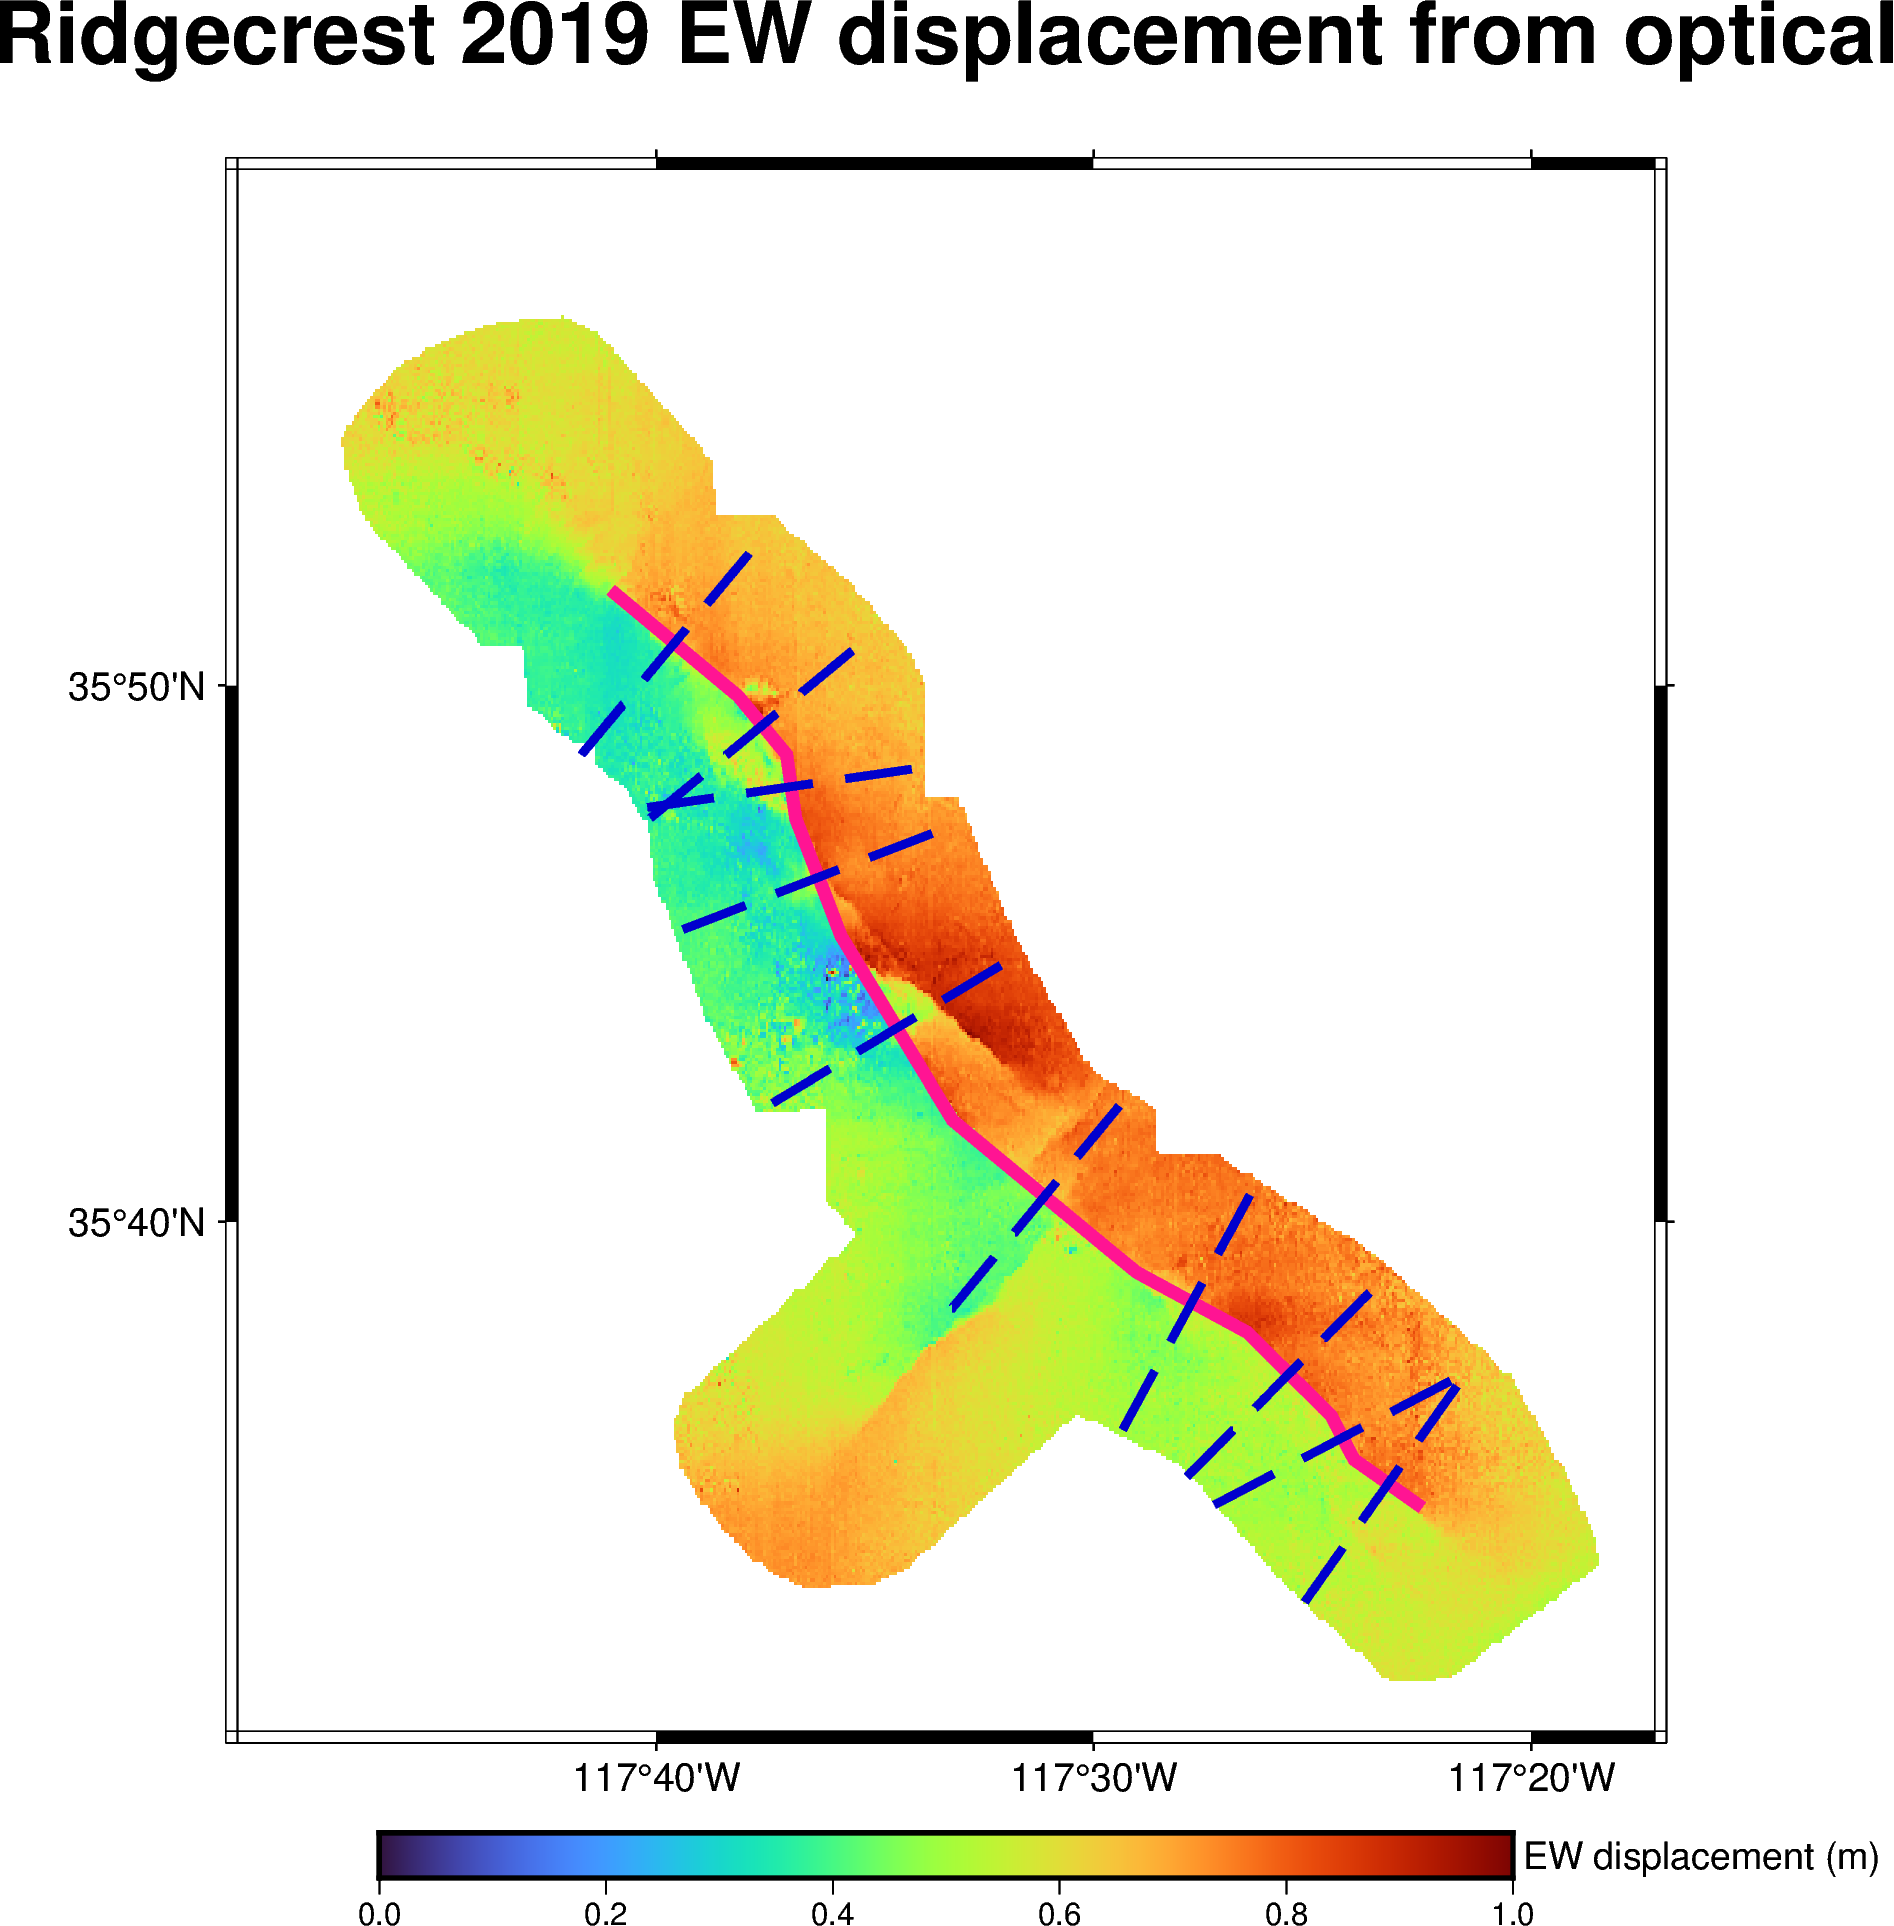

In [11]:
import rioxarray
import pygmt
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer

# Paths
ew_path = working_dir + "/qgis/EW_Ridgecrest_1m_utm.tif"
ns_path = working_dir + "/qgis/NS_Ridgecrest_1m_utm.tif"

# 1) Open GeoTIFFs with rioxarray (keeps CRS & coords)
ew = rioxarray.open_rasterio(ew_path)
ns = rioxarray.open_rasterio(ns_path)

# If files have a 'band' dimension, drop it
if "band" in ew.dims:
    ew = ew.squeeze("band", drop=True)
if "band" in ns.dims:
    ns = ns.squeeze("band", drop=True)

print(ew)
print("CRS:", ew.rio.crs)

# Downsample the UTM grids for faster profile extraction
ew_downsampled = ew[::100, ::100]
ns_downsampled = ns[::100, ::100]

# Reproject the downsampled grid to geographic coordinates (EPSG:4326) for mapping
# (we only reproject the downsampled grid used for plotting to save time)
ew_plot = ew_downsampled.rio.reproject("EPSG:4326")

# Make exact zeros transparent for plotting by turning them into NaN
ew_plot = ew_plot.where(ew_plot != 0)

# Build region in lon/lat order (xmin, xmax, ymin, ymax)
region = [
    float(ew_plot.x.min()), float(ew_plot.x.max()),
    float(ew_plot.y.min()), float(ew_plot.y.max()),
]
print("Region (lon/lat):", region)

# Prepare transformer to convert UTM coordinates (original ew.rio.crs) -> EPSG:4326
transformer = Transformer.from_crs(ew.rio.crs.to_string(), "EPSG:4326", always_xy=True)

# Convert fault trace coordinates (UTM -> lon/lat)
fault_xs = [438242, 442596, 444252, 444559, 446092, 449895, 456212, 460015, 462898, 463695, 466026]
fault_ys = [3968967, 3965287, 3963263, 3961055, 3957007, 3950628, 3945353, 3943268, 3940385, 3938852, 3937196]
fault_lons, fault_lats = transformer.transform(fault_xs, fault_ys)

# Create PyGMT figure using a simple Mercator map (uses lon/lat coordinates)
fig = pygmt.Figure()
projection = "M12c"  # map width 12 cm; uses lon/lat coordinates
fig.basemap(region=region, projection=projection,
            frame=['a', f'+tRidgecrest 2019 EW displacement from optical'])


# Show the raster (PyGMT will use the data range from the grid; zeros are NaN so they are transparent)
fig.grdimage(grid=ew_plot, cmap="turbo", projection=projection, region=region, nan_transparent=True)

# Plot the fault trace in lon/lat
fig.plot(x=fault_lons, y=fault_lats, pen="3p,deeppink", label="Fault Trace")

profiles = []
for i in range(len(fault_xs) - 1):
    segment_xs = [fault_xs[i], fault_xs[i+1]]
    segment_ys = [fault_ys[i], fault_ys[i+1]]

    # Build perpendicular profile in UTM (unchanged — used for sampling)
    profile_xs, profile_ys = get_perpendicular_profile(segment_xs, segment_ys, ew_downsampled)

    # Convert the profile coordinates to lon/lat for plotting on the map
    prof_lons, prof_lats = transformer.transform(profile_xs, profile_ys)
    fig.plot(x=prof_lons, y=prof_lats, pen="2p,mediumblue,--", label="Profiles" if i == 0 else "")

    # Sample values from the original (UTM) ew/ns grids for projection/inversion
    ew_profile = sample_profile_values(ew, profile_xs, profile_ys, method='linear')
    ns_profile = sample_profile_values(ns, profile_xs, profile_ys, method='linear')
    slip_dir = np.array([segment_xs[1] - segment_xs[0], segment_ys[1] - segment_ys[0]])
    slip_dir = slip_dir / np.linalg.norm(slip_dir)
    profiles_arr = np.column_stack([ew_profile, ns_profile])
    profile = profiles_arr @ slip_dir  # Project onto slip direction

    # compute cumulative distance along the profile for plotting
    coords = np.column_stack([profile_xs, profile_ys])
    dists = np.sqrt(((coords[1:] - coords[:-1])**2).sum(axis=1))
    dists = np.concatenate([[0.0], dists.cumsum()])
    seg_deltas = np.sqrt(((coords[1:] - coords[:-1])**2).sum(axis=1))
    cum_dists = np.concatenate([[0.0], seg_deltas.cumsum()])
    mid_x = (segment_xs[0] + segment_xs[1]) / 2.0
    mid_y = (segment_ys[0] + segment_ys[1]) / 2.0
    mid_dist_idx = np.argmin(np.sqrt((coords[:,0] - mid_x)**2 + (coords[:,1] - mid_y)**2))
    dists_zeroed = cum_dists - cum_dists[mid_dist_idx]

    profiles.append((dists_zeroed, profile, ew_profile, ns_profile, profile_xs, profile_ys, segment_xs, segment_ys))

# Colorbar uses the actual data range from the grid (zeros are NaN so won't compress the range)
fig.colorbar(cmap="turbo", frame=['a', 'y+lEW displacement (m)'])
fig.show()

## Bayesian inversion on each profile

In [ ]:
import pickle
noise_level = 0.15
vertical_segments = [
    { 'top': 0., 'bottom': 250. },
    { 'top': 250., 'bottom': 500. },
    { 'top': 500., 'bottom': 750. },
    { 'top': 750., 'bottom': 1000. },
    { 'top': 1000., 'bottom': 2000. },
    { 'top': 2000., 'bottom': 3000. },
    { 'top': 3000., 'bottom': 4000. },
    { 'top': 4000., 'bottom': 5000. },
    { 'top': 5000., 'bottom': 6000. },
    { 'top': 6000., 'bottom': 7000. },
    { 'top': 7000., 'bottom': 8000. },
    { 'top': 8000., 'bottom': 9000. },
    { 'top': 9000., 'bottom': 10000. },
    { 'top': 10000., 'bottom': 11000. },
    { 'top': 11000., 'bottom': 12000. },
    { 'top': 12000., 'bottom': 13000. },
    { 'top': 13000., 'bottom': 14000. },
    { 'top': 14000., 'bottom': 15000. }
]
results = []
for profile in profiles:
    dists, profile, ew_profile, ns_profile, profile_xs, profile_ys, segment_xs, segment_ys = profile
    dists[dists == 0.] = 1e-3  # avoid singularities
    Cd = noise_level**2 * np.eye(len(dists))
    print("nans", np.isnan(profile).any(), np.isnan(dists).any(), np.isnan(Cd).any())
    res = run_bayesian_inversion_segmented(dists, profile, vertical_segments, lin_center=[1.]*len(vertical_segments), C=Cd)
    print(res)
    results.append(res)

with open(f'{working_dir}/data/ridgecrest_segmented_profile_results.pickle', 'wb') as f:
    pickle.dump(results, f)

## Import results

In [16]:
import pickle
results = pickle.load(open(f'{working_dir}/data/ridgecrest_segmented_profile_results.pickle', 'rb'))
vertical_segments = [
    { 'top': 0., 'bottom': 250. },
    { 'top': 250., 'bottom': 500. },
    { 'top': 500., 'bottom': 750. },
    { 'top': 750., 'bottom': 1000. },
    { 'top': 1000., 'bottom': 2000. },
    { 'top': 2000., 'bottom': 3000. },
    { 'top': 3000., 'bottom': 4000. },
    { 'top': 4000., 'bottom': 5000. },
    { 'top': 5000., 'bottom': 6000. },
    { 'top': 6000., 'bottom': 7000. },
    { 'top': 7000., 'bottom': 8000. },
    { 'top': 8000., 'bottom': 9000. },
    { 'top': 9000., 'bottom': 10000. },
    { 'top': 10000., 'bottom': 11000. },
    { 'top': 11000., 'bottom': 12000. },
    { 'top': 12000., 'bottom': 13000. },
    { 'top': 13000., 'bottom': 14000. },
    { 'top': 14000., 'bottom': 15000. }
]

## Plot fit of inversion to data

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
seg0   0.005  0.005   0.000    0.013      0.000    0.000    3357.0    1949.0   
seg1   6.317  0.319   5.715    6.888      0.006    0.005    3237.0    2587.0   
seg2   9.525  0.446   8.696    9.999      0.007    0.010    3176.0    2409.0   
seg3   8.597  1.187   6.410    9.999      0.021    0.023    3322.0    2764.0   
seg4   1.564  0.585   0.524    2.730      0.011    0.010    2513.0    1702.0   
seg5   0.745  0.643   0.000    1.928      0.013    0.015    2751.0    1896.0   
seg6   0.720  0.666   0.001    1.985      0.009    0.013    4286.0    2181.0   
seg7   0.925  0.856   0.000    2.520      0.012    0.019    5241.0    2588.0   
seg8   1.238  1.136   0.001    3.371      0.016    0.024    4491.0    2085.0   
seg9   1.658  1.478   0.000    4.442      0.024    0.034    4565.0    2201.0   
seg10  2.091  1.814   0.000    5.556      0.027    0.034    4202.0    2842.0   
seg11  2.687  2.208   0.001    6.833    

/var/folders/x8/0bgl7hz50sl6ll21gjxcst0r0000gp/T/ipykernel_84388/4094943714.py:81: RuntimeWarning: divide by zero encountered in divide
  sol = (s / np.pi) * np.arctan(d / xs)
/var/folders/x8/0bgl7hz50sl6ll21gjxcst0r0000gp/T/ipykernel_84388/4094943714.py:81: RuntimeWarning: invalid value encountered in divide
  sol = (s / np.pi) * np.arctan(d / xs)


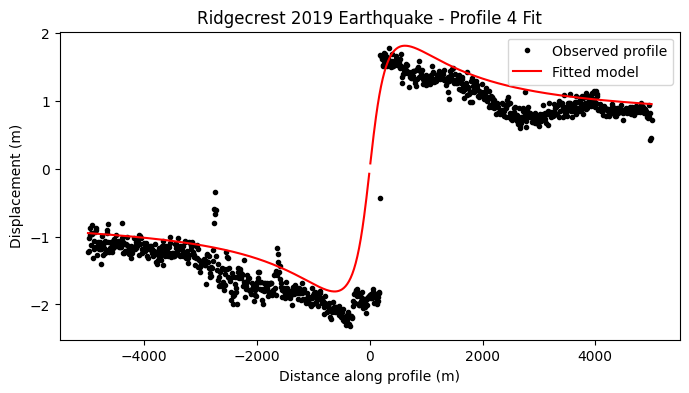

In [ ]:
i = 3
print(results[i])
dists, profile, ew_profile, ns_profile, profile_xs, profile_ys, segment_xs, segment_ys = profiles[i]
pred_func = pred_func_segmented_generator(dists, vertical_segments)
preds = pred_func(results[i]['mean'].values)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(dists, profile, 'k.', label='Observed profile')
ax.plot(dists, preds, 'r-', label='Fitted model')
ax.set_xlabel('Distance along profile (m)')
ax.set_ylabel('Displacement (m)')
ax.set_title(f'Ridgecrest 2019 Earthquake - Profile {i+1} Fit')
ax.legend()
plt.show()

## 2D slip distribution

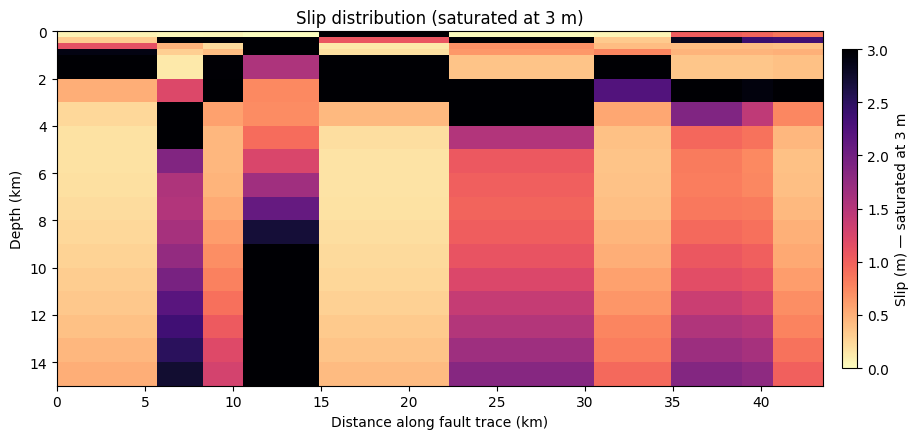

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# --- Prepare fault geometry in km (use same reference as your 3D code) ---
# If you already have x_ref_min/y_ref_min from the 3D cell, you can skip recomputing them.
# We'll compute a local reference from the original fault coordinates (meters) then convert to km.
x_ref_min = float(min(fault_xs))
y_ref_min = float(min(fault_ys))
xs_km = (np.array(fault_xs) - x_ref_min) / 1000.0
ys_km = (np.array(fault_ys) - y_ref_min) / 1000.0

# Node-to-node cumulative distance along the fault (km)
node_diffs = np.sqrt(np.diff(xs_km)**2 + np.diff(ys_km)**2)
node_cum = np.concatenate([[0.0], node_diffs.cumsum()])  # length = n_nodes

# Segment midpoints (km)
seg_midpoints = 0.5 * (node_cum[:-1] + node_cum[1:])
n_segments = len(seg_midpoints)

# Depth edges and centers in km (top=shallow, bottom=deep)
depth_tops = np.array([seg['top'] for seg in vertical_segments]) / 1000.0
depth_bots = np.array([seg['bottom'] for seg in vertical_segments]) / 1000.0
depth_edges = np.concatenate([depth_tops, [depth_bots[-1]]])  # gives edges length n_depths+1 if tops are consecutive
# If tops are not exactly contiguous, build edges explicitly:
depth_edges = np.array(
    [vertical_segments[0]['top'] / 1000.0] + 
    [seg['bottom'] / 1000.0 for seg in vertical_segments]
)
depth_centers = np.array([(seg['top'] + seg['bottom']) / 2.0 / 1000.0 for seg in vertical_segments])
n_depths = len(depth_centers)

# --- Collect slip into a 2D array: rows = depth levels (shallow->deep), cols = segments along fault ---
slip_matrix = np.full((n_depths, n_segments), np.nan, dtype=float)
for i in range(n_segments):
    # results[i] is the az.summary DataFrame; earlier code used results[i]['mean'].values
    slip_vals = np.array(results[i]['mean'].values, dtype=float)
    # Ensure slip_vals length matches number of depth levels
    if slip_vals.size != n_depths:
        raise RuntimeError(f"Segment {i}: expected {n_depths} slip values, got {slip_vals.size}")
    slip_matrix[:, i] = slip_vals

# Saturate slip at 3 m as in the 3D plot
vmax_saturate = 3.0
slip_plot = np.clip(slip_matrix, None, vmax_saturate)

# Global min for colormap lower bound (use 0 if you prefer)
vmin = np.nanmin(slip_plot)
if np.isnan(vmin):
    vmin = 0.0
vmin = min(0.0, vmin)  # ensure zero included if you want
vmax = vmax_saturate

# Build X and Y edges for pcolormesh:
# x edges are node_cum (segment boundaries), length n_segments+1
x_edges = node_cum
# y edges must be in ascending order from shallow to deep for pcolormesh
# construct from vertical_segments tops/ bottoms
y_edges = np.array([seg['top'] / 1000.0 for seg in vertical_segments] + [vertical_segments[-1]['bottom'] / 1000.0])

# Make figure
fig, ax = plt.subplots(figsize=(10, 4.5))

cmap = plt.cm.magma_r
norm = Normalize(vmin=vmin, vmax=vmax)

# pcolormesh expects shape (ny, nx) for the Z array where X edges length = nx+1 and Y edges length = ny+1
# slip_plot is (n_depths, n_segments) which matches pcolormesh expectations
pcm = ax.pcolormesh(x_edges, y_edges, slip_plot, cmap=cmap, norm=norm, shading='auto')

# Styling
ax.set_xlabel('Distance along fault trace (km)')
ax.set_ylabel('Depth (km)')
ax.set_title('Slip distribution (saturated at 3 m)')
ax.invert_yaxis()  # depth increases downward
ax.set_xlim(x_edges[0], x_edges[-1])

# Colorbar
cbar = fig.colorbar(pcm, ax=ax, pad=0.02, shrink=0.9)
cbar.set_label('Slip (m) — saturated at 3 m')

plt.tight_layout()
plt.show()

## 3D with cross section

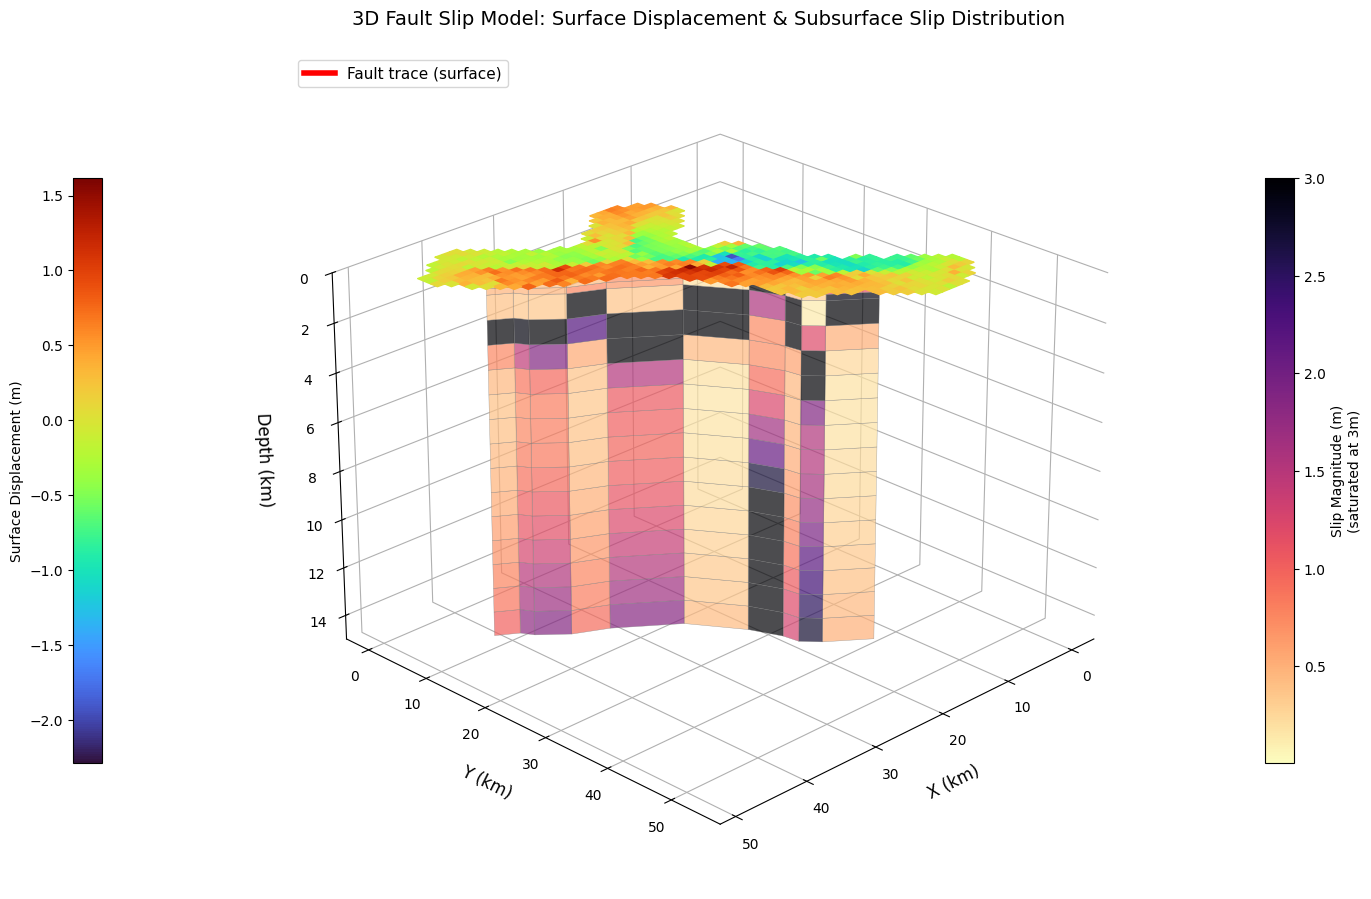

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pickle
import numpy as np

# Load results and data
results = pickle.load(open(f'{working_dir}/data/ridgecrest_segmented_profile_results.pickle', 'rb'))

import rioxarray
ew_path = working_dir + "/qgis/EW_Ridgecrest_1m_utm.tif"
ew = rioxarray.open_rasterio(ew_path)
if "band" in ew.dims:
    ew = ew.squeeze("band", drop=True)

# Downsample for 3D visualization
ew_downsampled = ew[::100, ::100]

# Define parameters
fault_xs = [438242, 442596, 444252, 444559, 446092, 449895, 456212, 460015, 462898, 463695, 466026]
fault_ys = [3968967, 3965287, 3963263, 3961055, 3957007, 3950628, 3945353, 3943268, 3940385, 3938852, 3937196]

vertical_segments = [
    { 'top': 0., 'bottom': 250. },
    { 'top': 250., 'bottom': 500. },
    { 'top': 500., 'bottom': 750. },
    { 'top': 750., 'bottom': 1000. },
    { 'top': 1000., 'bottom': 2000. },
    { 'top': 2000., 'bottom': 3000. },
    { 'top': 3000., 'bottom': 4000. },
    { 'top': 4000., 'bottom': 5000. },
    { 'top': 5000., 'bottom': 6000. },
    { 'top': 6000., 'bottom': 7000. },
    { 'top': 7000., 'bottom': 8000. },
    { 'top': 8000., 'bottom': 9000. },
    { 'top': 9000., 'bottom': 10000. },
    { 'top': 10000., 'bottom': 11000. },
    { 'top': 11000., 'bottom': 12000. },
    { 'top': 12000., 'bottom': 13000. },
    { 'top': 13000., 'bottom': 14000. },
    { 'top': 14000., 'bottom': 15000. }
]

# ============================================================
# STEP 1: Get coordinate reference from surface
# ============================================================
# Use the surface grid coordinates as reference to align everything
x_ref_min = float(ew_downsampled.x.values.min())
y_ref_min = float(ew_downsampled.y.values.min())

# Normalize fault coordinates using the SAME reference
fault_xs_norm = (np.array(fault_xs) - x_ref_min) / 1000.0
fault_ys_norm = (np.array(fault_ys) - y_ref_min) / 1000.0

# ============================================================
# STEP 2: Create 3D figure with adjusted layout
# ============================================================
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# ============================================================
# STEP 3: Plot surface with transparent zeros
# ============================================================
# Sample the surface data grid - normalize using same reference
x_surface = (ew_downsampled.x.values - x_ref_min) / 1000.0
y_surface = (ew_downsampled.y.values - y_ref_min) / 1000.0

# Create mesh for surface
X_surf, Y_surf = np.meshgrid(x_surface, y_surface)
Z_surf = np.zeros_like(X_surf)

# Create color array with transparency for zero values
surf_data = ew_downsampled.values
surf_min = np.nanmin(surf_data[surf_data != 0])  # Min excluding zeros
surf_max = np.nanmax(surf_data)

# Normalize surface data
surf_normalized = (surf_data - surf_min) / (surf_max - surf_min)

# Create RGBA array: initialize with turbo colors
cmap_turbo = plt.cm.turbo
colors_rgba = cmap_turbo(surf_normalized)

# Set alpha channel to 0 (transparent) for values exactly equal to 0
zero_mask = (surf_data == 0)
colors_rgba[zero_mask, 3] = 0  # Set alpha to 0 for zeros

# Plot surface with transparent zeros
im = ax.plot_surface(X_surf, Y_surf, Z_surf, facecolors=colors_rgba,
                     shade=False, antialiased=True)

# ============================================================
# STEP 4: Plot fault trace at surface
# ============================================================
ax.plot(fault_xs_norm, fault_ys_norm, 0, 'r-', linewidth=4, label='Fault trace (surface)', zorder=100)

# ============================================================
# STEP 5: Plot subsurface cross-sections with saturated slip colormap
# ============================================================
n_segments = len(fault_xs) - 1
cmap_slip = plt.cm.magma_r  # Reversed magma: higher values = darker

# Collect all slip values for normalization (saturated at 3m)
all_slip_values = []
for i in range(n_segments):
    slip_values = results[i]['mean'].values
    all_slip_values.extend(slip_values)

slip_min_global = np.nanmin(all_slip_values)
slip_max_saturated = 3.0  # Saturate at 3m

# Plot each segment as a vertical plane
for i in range(n_segments):
    x_start, x_end = fault_xs_norm[i], fault_xs_norm[i+1]
    y_start, y_end = fault_ys_norm[i], fault_ys_norm[i+1]
    
    # Get slip values for this segment
    slip_values = results[i]['mean'].values
    
    # Create depth array (in km)
    depths_km = np.array([(seg['top'] + seg['bottom']) / 2.0 / 1000.0 
                          for seg in vertical_segments])
    
    # Create 3D quadrilateral patches (rectangles) for each depth level
    for j in range(len(depths_km)):
        depth_top = vertical_segments[j]['top'] / 1000.0
        depth_bot = vertical_segments[j]['bottom'] / 1000.0
        slip_val = slip_values[j]
        
        # Normalize slip for colormap (saturated at 3m)
        slip_norm = np.clip((slip_val - slip_min_global) / (slip_max_saturated - slip_min_global), 0, 1)
        color = cmap_slip(slip_norm)
        
        # Define the four corners of the rectangle
        vertices = [
            [x_start, y_start, depth_top],  # corner 1: start at top depth
            [x_end, y_end, depth_top],      # corner 2: end at top depth
            [x_end, y_end, depth_bot],      # corner 3: end at bottom depth
            [x_start, y_start, depth_bot],  # corner 4: start at bottom depth
        ]
        
        # Create polygon and add to plot
        poly = [[vertices[0], vertices[1], vertices[2], vertices[3]]]
        ax.add_collection3d(Poly3DCollection(poly, alpha=0.7, facecolor=color, 
                                             edgecolor='grey', linewidth=0.3))
        
        # Add vertical edges at segment endpoints for clarity (lighter grey)
        if j == 0:  # Only draw these once per segment
            ax.plot([x_start, x_start], [y_start, y_start], 
                   [depth_top, depth_bot], color='grey', linewidth=0.8, alpha=0.4)
            ax.plot([x_end, x_end], [y_end, y_end], 
                   [depth_top, depth_bot], color='grey', linewidth=0.8, alpha=0.4)

# ============================================================
# STEP 6: Add vertical edges connecting segments
# ============================================================
for i in range(n_segments - 1):
    x_conn = fault_xs_norm[i+1]
    y_conn = fault_ys_norm[i+1]
    ax.plot([x_conn, x_conn], [y_conn, y_conn], [0, 15], 
           color='grey', linewidth=0.8, alpha=0.2)

# ============================================================
# STEP 7: Style the 3D plot background and gridlines
# ============================================================
# Set background to white
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')

# Set grid to light grey with reduced opacity
ax.grid(True, color='lightgrey', linewidth=0.5, alpha=0.5)
ax.xaxis.grid(True, color='lightgrey', linewidth=0.5, alpha=0.5)
ax.yaxis.grid(True, color='lightgrey', linewidth=0.5, alpha=0.5)
ax.zaxis.grid(True, color='lightgrey', linewidth=0.5, alpha=0.5)

# ============================================================
# STEP 8: Labels and formatting
# ============================================================
ax.set_xlabel('X (km)', fontsize=12, labelpad=10)
ax.set_ylabel('Y (km)', fontsize=12, labelpad=10)
ax.set_zlabel('Depth (km)', fontsize=12, labelpad=10)
ax.set_zlim(15, 0)  # Invert z-axis so depth increases downward

ax.set_title('3D Fault Slip Model: Surface Displacement & Subsurface Slip Distribution', 
            fontsize=14, pad=20)

# Set viewing angle
ax.view_init(elev=25, azim=45)

# ============================================================
# STEP 9: Add compact colorbars
# ============================================================
# Colorbar for surface displacement - positioned at bottom left
sm_surf = plt.cm.ScalarMappable(cmap='turbo', 
                                 norm=plt.Normalize(vmin=surf_min, vmax=surf_max))
sm_surf.set_array([])
cbar_surf = plt.colorbar(sm_surf, ax=ax, pad=0.12, shrink=0.5, aspect=20, 
                        orientation='vertical', location='left')
cbar_surf.set_label('Surface Displacement (m)', fontsize=10)

# Colorbar for subsurface slip - positioned at bottom right
sm_slip = plt.cm.ScalarMappable(cmap='magma_r', 
                                norm=plt.Normalize(vmin=slip_min_global, vmax=slip_max_saturated))
sm_slip.set_array([])
cbar_slip = plt.colorbar(sm_slip, ax=ax, pad=0.12, shrink=0.5, aspect=20, 
                        orientation='vertical', location='right')
cbar_slip.set_label('Slip Magnitude (m)\n(saturated at 3m)', fontsize=10)

ax.legend(loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()